In [40]:
#Prueba que las siguientes librerias estén disponibles

import cobra.test
import cplex # usaremos el cluster UTEM
import pandas as pd
import numpy as np
import escher
from escher import Builder

In [41]:
# Load fpkm data and model
#transcriptomic for e.coli in sheets: Ishii, Holm, Rintalta 
#wget -O S2.xls 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0157101.s002'

data=pd.read_excel("S2.xls",sheet_name="Transcriptomic data - Ishii", index_col=0, header=0) 
model2 = cobra.test.create_test_model("ecoli")
#model = cobra.test.create_test_model("ecoli")

In [42]:
model2

Name,iJO1366
Memory address,0x07f891c3a6850
Number of metabolites,1805
Number of reactions,2583
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [43]:
# Define una función para cargar los fpkm de acuerdo a las gene_reaction_rules

def getG(grl,fpkm):
    grl=grl.replace("(","")
    grl=grl.replace(")","")
    g = 0
    for subrule in grl.split("or"):
        g_subrule = []
        for gene in subrule.split("and"):
            gene = gene.replace(" ","")
            if gene in fpkm:
                g_subrule.append( float(fpkm[gene]) )
        if len(g_subrule)>=1: 
            g += min(g_subrule)
    return(g)

In [44]:
# Create a dictionary with the fpkm of each gene

fpkm={}

for gene in model2.genes:
    if gene.id  in data.index:
        fpkm[gene] = data["RF"].loc[gene.id]
    #else:
    #    print(gene.id," not found")

In [222]:
#fpkm

In [218]:
# Create a dictionary with the fpkm for each reaction
g = {}
mean_g = np.mean(list(fpkm.values()) ) # useful when not a grl available

for reaction in model2.reactions:
    if reaction.gene_reaction_rule == "":
        
        g[reaction.id] = mean_g[0]    
    else:
        g[reaction.id] = getG(reaction.gene_reaction_rule,fpkm)
        
#g.values()

     

In [216]:
reaction.model

Name,iJO1366
Memory address,0x07f890b213d10
Number of metabolites,1805
Number of reactions,2583
Number of groups,37
Objective expression,3.60030103098405*12DGR120tipp + 3.60030103098405*12DGR120tipp_reverse_757ef +...
Compartments,"cytosol, extracellular space, periplasm"


In [199]:
#1 Define objecive function
model2 = cobra.test.create_test_model("ecoli")

for i, reaction in enumerate(model2.reactions):
    if i == 0:
        dotProduct_expression  = model2.reactions.get_by_id(reaction.id).forward_variable*g[reaction.id]
        dotProduct_expression += model2.reactions.get_by_id(reaction.id).reverse_variable*g[reaction.id]
    else:
        dotProduct_expression += model2.reactions.get_by_id(reaction.id).forward_variable*g[reaction.id]
        dotProduct_expression += model2.reactions.get_by_id(reaction.id).reverse_variable*g[reaction.id]

In [205]:
dotProduct_objective = model2.problem.Objective(dotProduct_expression,direction="min")
model2.objective = dotProduct_objective 

In [206]:
#Fijación de glucosa
model2.reactions.get_by_id("EX_glc__D_e").bounds=(-1450,-1450)
model2.reactions.get_by_id("EX_glc__D_e").bounds

(-1450, -1450)

In [207]:
#2.3 Compute new distribution of fluxes
solution_SPOT2= model2.optimize()

In [208]:
solution_SPOT2

,fluxes,reduced_costs
DM_4crsol_c,-0.000000,-7.200602
DM_5drib_c,-0.000000,-7.200602
DM_aacald_c,-0.000000,-7.200602
DM_amob_c,-0.000000,-7.200602
DM_mththf_c,195.320925,-7.200602
...,...,...
ZN2abcpp,0.000000,2.740487
ZN2t3pp,0.000000,0.685122
ZN2tpp,0.000000,0.000000
ZNabcpp,0.000000,2.740487


In [209]:
#solution_SPOT2.fluxes

DM_4crsol_c     -0.000000
DM_5drib_c      -0.000000
DM_aacald_c     -0.000000
DM_amob_c       -0.000000
DM_mththf_c    195.320925
                  ...    
ZN2abcpp         0.000000
ZN2t3pp          0.000000
ZN2tpp           0.000000
ZNabcpp          0.000000
Zn2tex           0.000000
Name: fluxes, Length: 2583, dtype: float64

In [210]:
builder=Builder(
    map_name="e_coli_core.Core metabolism",
    model_name="e_coli_core",
)
builder.reaction_data=solution_SPOT2.fluxes
builder

Builder(reaction_data={'DM_4crsol_c': -0.0, 'DM_5drib_c': -0.0, 'DM_aacald_c': -0.0, 'DM_amob_c': -0.0, 'DM_mt…

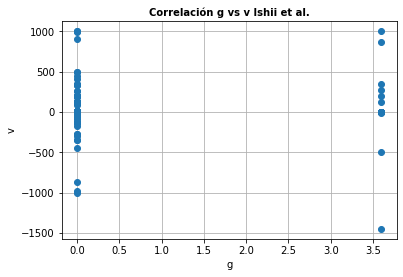

In [211]:
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt

#Definiendo ejes

x=g.values()
y=solution_SPOT2.fluxes
#Etiquetas de titulo y ejes
plt.plot(x,y[0:], 'o')

plt.title('Correlación g vs v Ishii et al.',fontsize = 10,fontweight = "bold")
plt.xlabel('g')
plt.ylabel('v')


plt.grid()
plt.show()

In [219]:
flujos=['PGI','PFK','FBA','TPI',"GAPD","PYK","PDH","GND","RPE","RPI","TKT1","TALA","TKT2","CS","ACONTa","ICDHyr","SUCDi","FUM","PPC","ICL"]
#valores EXPERIMENTALES isshi
flux_ex={'PGI':224.7179186,'PFK':249.5301258,'FBA':249.5301258,'TPI':249.5301258,'GAPD':504.7619031,
         'PYK':139.9624166,'PDH':372.2827564,'GND':64.39079794,'RPE':26.84455913,'RPI':37.54514687,
     'TKT1':17.83978343,'TALA':17.83978343,'TKT2':9.003823619,'CS':257.7498473,'ACONTa':257.7498473,
         'ICDHyr':257.7498473,'SUCDi':233.664,'FUM':233.664,'PPC':30.92421098,'ICL':32.68244693}

In [220]:
flux_pr=[]
flux_exl=[]
for i in flujos:    
    model2.reactions.get_by_id(i)
    #print (model.reactions.get_by_id(i), model.reactions.get_by_id(i).name)
    print (i,'|',solution_SPOT2[i],'|',flux_ex[i])
    flux_exl.append(flux_ex[i])
    flux_pr.append(solution_SPOT2[i])

PGI | 335.6647081122038 | 224.7179186
PFK | 0.0 | 249.5301258
FBA | 0.0 | 249.5301258
TPI | -92.936467020474 | 249.5301258
GAPD | 136.6446171341912 | 504.7619031
PYK | 0.0 | 139.9624166
PDH | 128.27862016679182 | 372.2827564
GND | 114.33529188779642 | 64.39079794
RPE | -63.28597422289289 | 26.84455913
RPI | -169.2552691432901 | 37.54514687
TKT1 | -26.06565579984681 | 17.83978343
TALA | -292.8670583775581 | 17.83978343
TKT2 | -37.22031842304608 | 9.003823619
CS | 13.943328278999473 | 257.7498473
ACONTa | 13.943328278999473 | 257.7498473
ICDHyr | 13.943328278999473 | 257.7498473
SUCDi | 13.943328278999502 | 233.664
FUM | 13.943328278999502 | 233.664
PPC | 0.0 | 30.92421098
ICL | 0.0 | 32.68244693


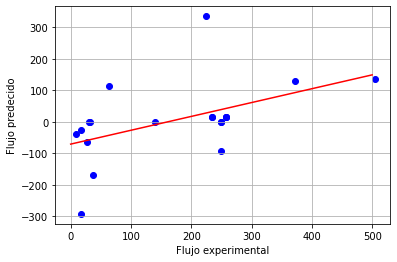

In [221]:
#plot entre predecido y experimental

x=flux_exl
y=flux_pr

plt.scatter(x,y,c="blue")
plt.xlabel('Flujo experimental')
plt.ylabel('Flujo predecido')

#Agregar Linea de tendencia por medio de Minimos Cuadrados Ordinarios 
m=np.array([np.ones(20),x]).T #Para ejecutar de forma correcta la ec. Beta es necesario agregar una columna de 1 en el eje X
B=np.linalg.inv(m.T @m) @ m.T @y #ec. beta para realizar la linea de tendencia

plt.plot([0,500],[B[0]+B[1]*1,B[0]+B[1]*500],c="red") # Linea de tendencia

plt.grid()
plt.show()